In [2]:
import time
import numpy as np
import pandas as pd
import operator
from collections import Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from scipy.sparse.construct import hstack

import xgboost as xgb
#import lightgbm as lgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import ParameterGrid
#from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from contextlib import contextmanager
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name} done in {time.time() - start_time:.2f} s]')

In [3]:
train = pd.read_csv('data/processed_train.csv')
test = pd.read_csv('data/processed_test.csv')
print(Counter(train['day']).keys())
print(Counter(test['day']).keys())

dict_keys([17, 18, 19, 20, 21, 22, 23, 24])
dict_keys([25, 24])


In [4]:
# sort data according to day and time
train = train.sort_values(by = ['day','time']).reset_index().iloc[:, 1:]
# convert hour to time slot
# is_midnight: 0, is_morning: 1, is_afternoon: 2, is_night: 3
def f(x):
    if x <= 7:
        return 0
    elif x > 7 and x <= 13:
        return 1
    elif x > 13 and x <= 19:
        return 2
    else:
        return 3
train['hour'] = train['hour'].apply(lambda x: f(x))

In [5]:
# delete some features
# check importance of features
exclude_features = ['instance_id','context_id', 'context_timestamp', 'is_trade','datetime', 'day', 'time']
df_train = train[(train['day'] >= 17) & (train['day'] <= 22)]
df_val = train[(train['day'] >= 23) & (train['day'] <= 24)]
y_train = df_train['is_trade']
x_train = df_train.drop(exclude_features, axis = 1)
y_val = df_val['is_trade']
x_val = df_val.drop(exclude_features, axis = 1)

In [6]:
df_train.to_csv('data/df_train.csv',index=None)
df_val.to_csv('data/df_val.csv', index = None)
y_train.to_csv('data/y_train.csv', index = None)
x_train.to_csv('data/x_train.csv', index =None)
y_val.to_csv('data/y_val.csv', index = None)
x_val.to_csv('data/x_val.csv', index = None)

In [7]:
def show_result(model, dtrain_x, dval_x, dtrain_y, dval_y ):
    y_pred_dtrain = model.predict_proba(dtrain_x)
    y_pred_val = model.predict_proba(dval_x)
    xgb_train_logloss = log_loss(dtrain_y, y_pred_dtrain)
    xgb_val_logloss = log_loss(dval_y, y_pred_val)
    plt.rcParams['figure.figsize'] = 12, 6
    fscore = pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False)
    fscore.plot(kind = 'bar',title = 'Feature Importance')
    plt.ylabel('Feature Importance Score')
    print("Logloss Score(Train): %f"%xgb_train_logloss)
    print("Logloss Score(Val): %f"%xgb_val_logloss)

In [10]:
xgboost1 = xgb.XGBClassifier(nthread = 25, learning_rate = 0.05, n_estimator = 500,
                           max_depth = 8, subsample = 0.7, colsample_bytree = 0.5, 
                             min_child_weight = 10, seed = 123, objective = 'binary:logistic')

In [11]:
xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = 100)

[0]	validation_0-logloss:0.648111	validation_1-logloss:0.647771
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
[99]	validation_0-logloss:0.084535	validation_1-logloss:0.07839


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimator=500,
       n_estimators=100, n_jobs=1, nthread=25, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=123, silent=True, subsample=0.7)

Logloss Score(Train): 0.084535
Logloss Score(Val): 0.078390


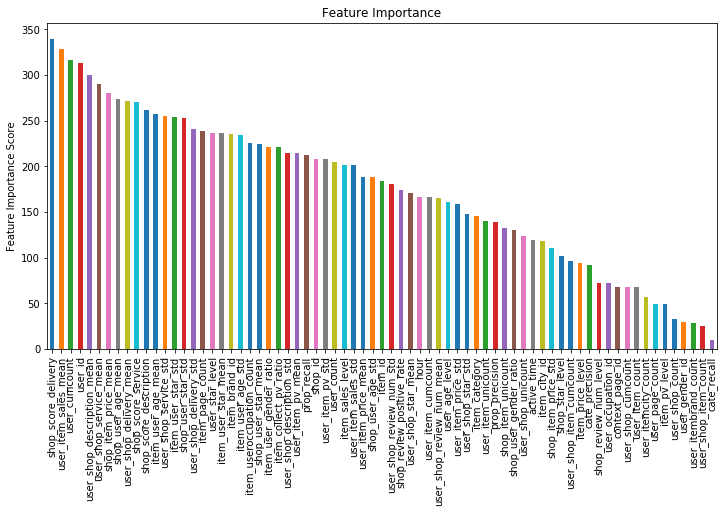

In [9]:
show_result(xgboost1, x_train, x_val, y_train, y_val)

In [67]:
t = {'n_estimator':99}
xgboost1.set_params(**t)
xgboost1.save_model('model/xgboost_78_start')

In [81]:
# Tune max_depth and min_child_weight
# 'max_depth':range(3,10,2),range(10,15,1)
# 'min_child_weight':range(1,15,2), range(1,8,1)
# 9,1,0.78386; 10,2,0.78381
# best max_depth = 11, min_child_weight = 2, best_logloss = 0.078354
grid1 = {
    'max_depth':range(11,12,1),
    'min_child_weight':range(2,3,1)
}
best_logloss = 0.07839
with timer('Tune max_depth and min_child_weight: '):
    for g in ParameterGrid(grid1):
        xgboost1.set_params(**g)
        print('----------- -------------')
        xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost1.get_booster().best_score)
        if xgboost1.get_booster().best_score < best_logloss:
            best_logloss = xgboost1.get_booster().best_score
            print('Best so far!')
            print('max_depth: ', xgboost1.get_params()['max_depth'])
            print('min_child_weight: ', xgboost1.get_params()['min_child_weight'])
            print('Minimal logloss', best_logloss)          

----------- -------------
logloss:  0.078354
Best so far!
max_depth:  11
min_child_weight:  2
Minimal logloss 0.078354
[Tune max_depth and min_child_weight:  done in 420.37 s]


In [93]:
# Tune gamma
# best gamma = 0
t = {'n_estimator':99,'max_depth':11, 'min_child_weight': 2}
xgboost1.set_params(**t)

grid2 ={
    'gamma': [i/10.0 for i in range(0,5)]
}
best_logloss = 0.078354
with timer('Tune gamme: '):
    for g in ParameterGrid(grid2):
        xgboost1.set_params(**g)
        print('----------- -------------')
        xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost1.get_booster().best_score)
        if xgboost1.get_booster().best_score < best_logloss:
            best_logloss = xgboost1.get_booster().best_score
            print('Best so far!')
            print('gamma: ', xgboost1.get_params()['gamma'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.078354
----------- -------------
logloss:  0.078444
----------- -------------
logloss:  0.078417
----------- -------------
logloss:  0.078416
----------- -------------
logloss:  0.078446
[Tune gamme:  done in 2143.38 s]


In [97]:
# Tune subsample and colsample_bytree
t = {'n_estimator':99,'max_depth':11, 'min_child_weight': 2,'gamma':0}
xgboost1.set_params(**t)

# 'subsample': [i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# 0.9; 0.81,0.82,0.83,0.84,0.85
# best subsample: 0.9, colsample_bytree: 0.8, best_logloss = 0.078208
grid3 ={
    'subsample': [0.9],
    'colsample_bytree':[0.8]
}
best_logloss = 0.078354
with timer('Tune subsample and colsample_bybree: '):
    for g in ParameterGrid(grid3):
        xgboost1.set_params(**g)
        print('----------- -------------')
        xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost1.get_booster().best_score)
        if xgboost1.get_booster().best_score < best_logloss:
            best_logloss = xgboost1.get_booster().best_score
            print('Best so far!')
            print('subsample: ', xgboost1.get_params()['subsample'])
            print('colsample_bytree: ', xgboost1.get_params()['colsample_bytree'])
            print('Minimal logloss', best_logloss)          

----------- -------------
logloss:  0.078208
Best so far!
subsample:  0.9
colsample_bytree:  0.8
Minimal logloss 0.078208
[Tune subsample and colsample_bybree:  done in 584.08 s]


In [102]:
# Tuning Regularization Parameters
t = {'n_estimator':99,'max_depth':11, 'min_child_weight': 2,'gamma':0, 'subsample':0.9, 'colsample_bytree': 0.8}
xgboost1.set_params(**t)
# Tune reg_alpha
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# 'reg_alpha':[0.01,0.02]
# best reg_alpha = 0.005
grid4 ={
    'reg_alpha':[0.005]
}
best_logloss = 0.078182
with timer('Tune reg_alpha: '):
    for g in ParameterGrid(grid4):
        xgboost1.set_params(**g)
        print('----------- -------------')
        xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost1.get_booster().best_score)
        if xgboost1.get_booster().best_score < best_logloss:
            best_logloss = xgboost1.get_booster().best_score
            print('Best so far!')
            print('reg_alphs: ', xgboost1.get_params()['reg_alpha'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.078182
[Tune reg_alpha:  done in 580.77 s]


In [106]:
# Tuning Regularization Parameters
t = {'n_estimator':99,'max_depth':11, 'min_child_weight': 2,'gamma':0, 'subsample':0.9, 'colsample_bytree': 0.8,'reg_alpha':0.005}
xgboost1.set_params(**t)
# Tune reg_lambda
# 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
# 'reg_lambda':[0.01,0.02]
# 'reg_lambda':[0.05, 0.06, 0.07,0.88,0.89, 0.91, 0.92, 0.94, 0.96, 0.98,1.02,1.04, 1.06, 1.5]
# best reg_lambda = 1
grid5 ={
    'reg_lambda':[1]
}
best_logloss = 0.078182
with timer('Tune reg_lambda: '):
    for g in ParameterGrid(grid5):
        xgboost1.set_params(**g)
        print('----------- -------------')
        xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost1.get_booster().best_score)
        if xgboost1.get_booster().best_score < best_logloss:
            best_logloss = xgboost1.get_booster().best_score
            print('Best so far!')
            print('reg_lambda: ', xgboost1.get_params()['reg_lambda'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.078182
[Tune reg_lambda:  done in 562.42 s]


In [110]:
# Tuning scale_pos_weight
t = {'n_estimator':99,'max_depth':11, 'min_child_weight': 2,'gamma':0, 
     'subsample':0.9, 'colsample_bytree': 0.8,'reg_alpha':0.005, 'reg_lambda':1}
xgboost1.set_params(**t)
# Tune scale_pos_weight
# 'scale_pos_weight':[0,0.1,0.11,0.12,0.2,0.5,0.7,0.8,0.9]
# 'scale_pos_weight':[0.55,0.6, 0.65,0.67,0.72]
# best logloss = 0.077521
# best scale_pos_weight: 0.63

grid6 ={
    'scale_pos_weight':[0.63,0.64,0.65,0.66]
}
best_logloss = 0.0.077445
with timer('Tune scale_pos_weight: '):
    for g in ParameterGrid(grid6):
        xgboost1.set_params(**g)
        print('----------- -------------')
        xgboost1.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost1.get_booster().best_score)
        if xgboost1.get_booster().best_score < best_logloss:
            best_logloss = xgboost1.get_booster().best_score
            print('Best so far!')
            print('scale_pos_weight: ', xgboost1.get_params()['scale_pos_weight'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.077445
Best so far!
scale_pos_weight:  0.63
Minimal logloss 0.077445
----------- -------------
logloss:  0.077539
----------- -------------
logloss:  0.077447
----------- -------------
logloss:  0.077509
[Tune reg_lambda:  done in 2130.78 s]


In [112]:
t = {'n_estimator':99,'max_depth':11, 'min_child_weight': 2,'gamma':0, 
     'subsample':0.9, 'colsample_bytree': 0.8,'reg_alpha':0.005, 
     'reg_lambda':1,'scale_pos_weight':0.63}
xgboost1.set_params(**t)
xgboost1.save_model('model/xgboost_78_final')

Logloss Score(Train): 0.072778
Logloss Score(Val): 0.077509


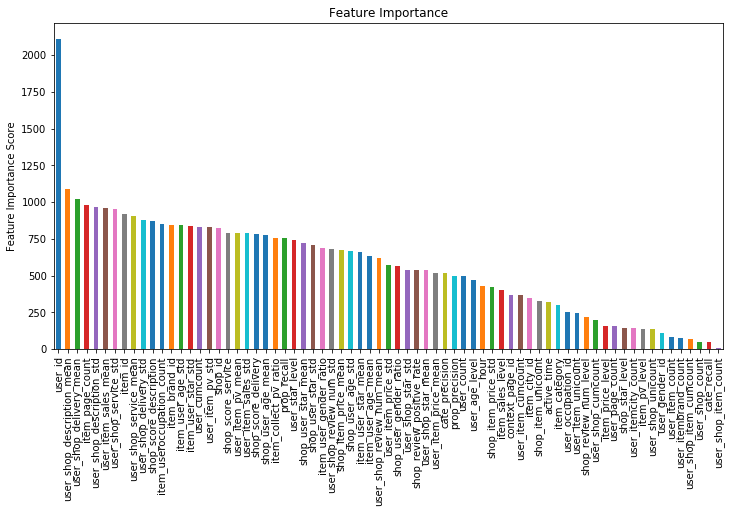

In [113]:
show_result(xgboost1, x_train, x_val, y_train, y_val)

Now we can see a significant boost in performance and the effect of parameter tuning is clearer.

As we come to the end, I would like to share 2 key thoughts:

1. It is difficult to get a very big leap in performance by just using parameter tuning or slightly better models. The max score for GBM was 0.8487 while XGBoost gave 0.8494. This is a decent improvement but not something very substantial.   

2. A significant jump can be obtained by other methods like feature engineering, creating ensemble of models, stacking, etc

In [118]:
#xgboost1.get_booster().best_iteration
#xgboost1.get_booster().best_score
#xgboost1.get_params()